In [ ]:
import warnings

import pandas as pd
import torch
import re
import nltk

from tqdm import tqdm
from transformers import AdamW, RobertaTokenizer
from transformers import RobertaForSequenceClassification
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset
from nltk.stem import WordNetLemmatizer
from transformers import AdamW, get_scheduler
import torch.nn as nn
from torch.utils.data import Dataset

warnings.filterwarnings('ignore')

In [ ]:
# This refers to `b. Datasets\XYZ Store - Item Reviews`
train_data = pd.read_csv('/kaggle/input/nlphackathondata/Train Data.csv')
test_data = pd.read_csv('/kaggle/input/nlphackathondata/Test Data.csv')

In [3]:
train_data.fillna(" ", inplace=True)
test_data.fillna(" ", inplace=True)

In [4]:
# train_data = pd.read_csv("/kaggle/input/nlp-hackathon-smallsubset/Train Data - Very Small.csv")
# test_data = pd.read_csv("/kaggle/input/nlp-hackathon-smallsubset/Test Data - Very Small.csv")

In [5]:
nltk.data.path.append('/kaggle/input/nltk-stopwrods/stopwords')

# # Test if NLTK can access stopwords
from nltk.corpus import stopwords
print(stopwords.words('english')[:10]) 

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [6]:
nltk.data.path.append('/kaggle/input/nltk-wordnet')

# Test if wordnet is working
from nltk.corpus import wordnet
print(wordnet.synsets('example'))

[Synset('example.n.01'), Synset('model.n.07'), Synset('exemplar.n.01'), Synset('example.n.04'), Synset('case.n.01'), Synset('exercise.n.04')]


In [7]:
# nltk.download('stopwords')
# nltk.download('wordnet')

# Initialisations
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    Function to clean and preprocess text data.
    """
    # Convert to lowercase
    text = text.lower()

    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords and lemmatise
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]

    # Join tokens back to text
    return " ".join(tokens)

# Apply pre-processing to training and test data
train_data['Cleaned_Review'] = train_data['Review'].apply(preprocess_text)
test_data['Cleaned_Review'] = test_data['Review'].apply(preprocess_text)

In [8]:
display(train_data.head(2))
display(train_data.tail(2))
display(test_data.head(2))
display(test_data.tail(2))

,ID,Review_Title,Review,Rating,Cleaned_Review
0,0,good product,fine at this price\r\n,1,fine price
1,1,Worth the money,Best quality materials,1,best quality material


,ID,Review_Title,Review,Rating,Cleaned_Review
44796,49123,Could be way better,Just okay,0,okay
44797,49124,One Star\r\n,Not good\r\n,0,good


,ID,Review_Title,Review,Cleaned_Review
0,0,Super!,Good cooling low noise. Better Daily change th...,good cooling low noise better daily change wat...
1,1,Brilliant,Awesome,awesome


,ID,Review_Title,Review,Cleaned_Review
14930,16373,Classy product,it's wonderful!,wonderful
14931,16374,great ear phone\n,great\n,great


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
class ReviewDataset(Dataset):
    def __init__(self, reviews, tokenizer, labels=None, max_len=256):
        """
        Args:
            reviews: List of review texts.
            tokenizer: BERT tokenizer instance.
            labels: Optional, list of target labels.
            max_len: Maximum length of tokenized sequences.
        """
        self.reviews = reviews
        self.labels = labels  # Labels can be None for test data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        # Retrieve a single review and convert it to string
        review = str(self.reviews[item])

        # Tokenize the review
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Prepare dictionary for model input
        data = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }

        # Add label only for training/validation data
        if self.labels is not None:
            data['labels'] = torch.tensor(self.labels[item], dtype=torch.long)

        return data

In [11]:
# Combine 'Cleaned_Review' and 'Review_Title' into a single text column
train_data_review_values = train_data['Review_Title'] + " " + train_data['Cleaned_Review']
test_data_review_values = test_data['Review_Title'] + " " + test_data['Review_Title']

In [12]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Prepare Train Dataset
train_dataset = ReviewDataset(
    reviews=train_data_review_values.values,  # Pass cleaned reviews
    labels=train_data['Rating'].values,  # Pass labels
    tokenizer=tokenizer,
    max_len=256
)

# Create Test Dataset (No labels)
test_dataset = ReviewDataset(
    reviews=test_data_review_values.values,
    tokenizer=tokenizer
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [13]:
class ReviewDataset(Dataset):
    def __init__(self, reviews, tokenizer, labels=None, max_len=256):
        """
        Args:
            reviews: List of review texts.
            tokenizer: BERT tokenizer instance.
            labels: Optional, list of target labels (for training).
            max_len: Maximum length of tokenized sequences.
        """
        self.reviews = reviews
        self.labels = labels  # Labels can be None for test data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        # Retrieve a single review and convert it to string
        review = str(self.reviews[item])

        # Tokenize the review
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Prepare dictionary for model input
        data = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }

        # Add label if it exists (for training only)
        if self.labels is not None:
            data['labels'] = torch.tensor(self.labels[item], dtype=torch.long)

        return data

In [14]:
# Define hyperparameters to test
# learning_rates = [5e-5, 3e-5, 2e-5]
learning_rates = [3e-5]
batch_sizes = [32]
epochs = 4

best_accuracy = 0
best_params = {}

# Grid search for hyperparameters
for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Testing: LR={lr}, Batch Size={batch_size}")

        # Re-initialize dataset and dataloaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

        # Re-initialize model and optimizer
        model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
        model = model.to(device)
        optimizer = AdamW(model.parameters(), lr=lr)

        # Learning rate scheduler
        scheduler = get_scheduler('linear', optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)

        # Training loop
        for epoch in range(epochs):
            model.train()
            for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} Training", unit="batch"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                optimizer.zero_grad()
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                loss.backward()

                # Gradient clipping
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                optimizer.step()
                scheduler.step()

        # Evaluate model performance
        model.eval()
        predictions, true_labels = [], []
        with torch.no_grad():
            for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} Training", unit="batch"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1)
                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        accuracy = accuracy_score(true_labels, predictions)
        print(f"Accuracy for LR={lr}, Batch Size={batch_size}: {accuracy}")

        # Save best parameters
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'learning_rate': lr, 'batch_size': batch_size}
            # Save the model
            torch.save(model.state_dict(), "best_model.pt")

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

Testing: LR=3e-05, Batch Size=32


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 4/4 Training: 100%|██████████| 1400/1400 [06:06<00:00,  3.82batch/s]


Accuracy for LR=3e-05, Batch Size=32: 0.9976115005134157
Best Hyperparameters: {'learning_rate': 3e-05, 'batch_size': 32}
Best Accuracy: 0.9976115005134157


In [15]:
# Save the Fine-Tuned Model
torch.save(model.state_dict(), "fine_tuned_resnet50.pth")

In [16]:
# Load the best hyperparameters
best_lr = best_params['learning_rate']
best_batch_size = best_params['batch_size']

# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

# Reinitialise model and load the saved weights
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
model.load_state_dict(torch.load("best_model.pt"))  # Load saved weights
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Make predictions on test data
predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
best_batch_size

32

In [18]:
df = pd.DataFrame({
    'ID': test_data['ID'],
    'Rating': predictions
    })

display(df.head(2))
display(df.tail(2))

,ID,Rating
0,0,1
1,1,1


,ID,Rating
14930,16373,1
14931,16374,1


In [19]:
df.to_csv('NLP_Hackathon_GC_Mini_2.csv', index=False)

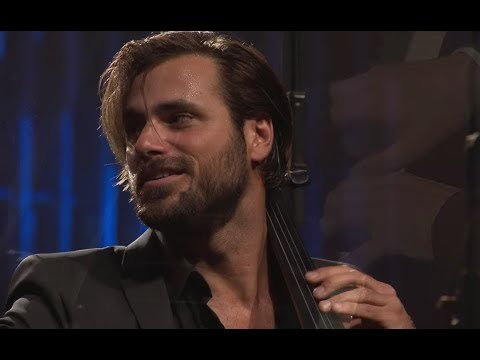

In [20]:
from IPython.display import YouTubeVideo

# Replace with your desired YouTube video ID
video_id = "g91kQyy4G7E"
YouTubeVideo(video_id, width=800, height=450, allow_autoplay=True)